In [886]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import random
import seaborn as sns
from sklearn.feature_extraction import FeatureHasher
from sklearn.linear_model import LogisticRegression
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split



In [897]:
from catboost import Pool, CatBoostRegressor, cv

In [285]:
df = pd.read_csv('Wine.csv')
df.drop(["taster_twitter_handle", "description", "title"],axis = 1, inplace = True)
df.dropna(subset = ['price'], inplace =True)
#df = df[df['price'] < 150]


In [890]:
df

,Unnamed: 0,country,designation,points,price,province,region_1,region_2,taster_name,variety,winery
1,1,Portugal,Avidagos,87,15.0,Douro,0,0,Roger Voss,Portuguese Red,Quinta dos Avidagos
2,2,US,0,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,Pinot Gris,Rainstorm
3,3,US,Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,0,Alexander Peartree,Riesling,St. Julian
4,4,US,Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,Pinot Noir,Sweet Cheeks
5,5,Spain,Ars In Vitro,87,15.0,Northern Spain,Navarra,0,Michael Schachner,Tempranillo-Merlot,Tandem
...,...,...,...,...,...,...,...,...,...,...,...
129966,129966,Germany,Brauneberger Juffer-Sonnenuhr Spätlese,90,28.0,Mosel,0,0,Anna Lee C. Iijima,Riesling,Dr. H. Thanisch (Erben Müller-Burggraef)
129967,129967,US,0,90,75.0,Oregon,Oregon,Oregon Other,Paul Gregutt,Pinot Noir,Citation
129968,129968,France,Kritt,90,30.0,Alsace,Alsace,0,Roger Voss,Gewürztraminer,Domaine Gresser
129969,129969,France,0,90,32.0,Alsace,Alsace,0,Roger Voss,Pinot Gris,Domaine Marcel Deiss


In [427]:
labels = df.columns
labels

Index(['Unnamed: 0', 'country', 'designation', 'points', 'price', 'province',
       'region_1', 'region_2', 'taster_name', 'variety', 'winery'],
      dtype='object')

In [557]:
df = df.dropna(subset = ['country'])

In [558]:
n = len(df)
for label in labels:
  num = sum(df[label].isna())
  print(label + ': ' + str(num) + '  ' +str(num/n*100) + '%'  )
# We will delete all country missing items, since it only have 59 and in reality, 
# people will eventually know where the wine produced.


Unnamed: 0: 0  0.0%
country: 0  0.0%
designation: 34768  28.753845644910513%
points: 0  0.0%
price: 0  0.0%
province: 0  0.0%
region_1: 19516  16.140130338416753%
region_2: 70624  58.40748949684078%
taster_name: 24496  20.25869198451818%
variety: 1  0.0008270204108637402%
winery: 0  0.0%


In [559]:
for label in labels:
  num_unique = len(np.unique(list(df[label])))
  num_total = len(df.dropna(subset = [label]))
  print(label + ': ' + str(num_unique))

Unnamed: 0: 120916
country: 42
designation: 35754
points: 21
price: 390
province: 422
region_1: 1205
region_2: 18
taster_name: 20
variety: 692
winery: 15843


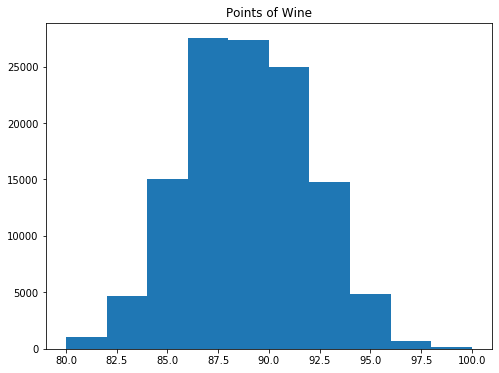

In [287]:
fig, ax = plt.subplots(figsize = (8,6))
ax.hist(df['points'],range=[80, 100])
ax.set_title('Points of Wine')
plt.show()

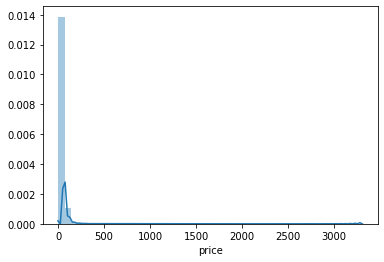

In [288]:
ax = sns.distplot(df["price"])

In [777]:
# 1% of wine in our data greater han $150

data = df[df['price']<150]
1-data.size/df.size

0.012157200039697003

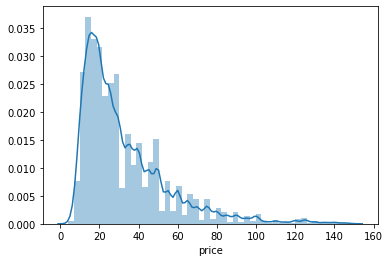

In [561]:
ax = sns.distplot(data["price"])

In [562]:
np.corrcoef(df['price'], df['points'])

array([[1.        , 0.41619727],
       [0.41619727, 1.        ]])

Analyze the correlation of winery to province/region_1/region_2/variety/country

In [290]:
# https://stackoverflow.com/questions/46498455/categorical-features-correlation/46498792#46498792

import pandas as pd
import numpy as np
import scipy.stats as ss
import seaborn as sns

def cramers_v(confusion_matrix):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher,
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))


In [550]:
df_cor = ['country', 'region_1','region_2','province','taster_name','variety','designation', 'winery']
for j in df_cor:
    x = data['country']
    y = data[j]
    confusion_matrix = pd.crosstab(x, y).values
    cor = cramers_v(confusion_matrix)
    print("correlation of " + j + " = "+str(cor))

correlation of country = 1.0
correlation of region_1 = 0.9938399480672263
correlation of region_2 = nan
correlation of province = 0.9984116896249929
correlation of taster_name = 0.6064941814129171


C:\YZC\Conda\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in double_scalars


correlation of variety = 0.5023888316816095
correlation of designation = 0.635795192386344
correlation of winery = 0.9272439291503246


In [132]:
for j in df_cor:
    x = data['winery']
    y = data[j]
    confusion_matrix = pd.crosstab(x, y).values
    cor = cramers_v(confusion_matrix)
    print("correlation of " + j + " = "+str(cor))

correlation of country = 0.9272439291503246
correlation of region_1 = 0.5997890217017628
correlation of region_2 = 0.8225770302898886
correlation of province = 0.7233989790886322
correlation of taster_name = 0.7901444633112727
correlation of variety = 0.3970457319913873
correlation of designation = 0.5690081222002432
correlation of winery = 1.0000000000000013


In [133]:
for j in df_cor:
    x = data['region_2']
    y = data[j]
    confusion_matrix = pd.crosstab(x, y).values
    cor = cramers_v(confusion_matrix)
    print("correlation of " + j + " = "+str(cor))

C:\YZC\Conda\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in double_scalars


correlation of country = nan
correlation of region_1 = 0.9980666782738485
correlation of region_2 = 1.0
correlation of province = 0.9998696761446675
correlation of taster_name = 0.5757108659745721
correlation of variety = 0.28024796218274156
correlation of designation = 0.5959496514234616
correlation of winery = 0.8225770302898887


In [551]:
for j in df_cor:
    x = data['region_1']
    y = data[j]
    confusion_matrix = pd.crosstab(x, y).values
    cor = cramers_v(confusion_matrix)
    print("correlation of " + j + " = "+str(cor))

correlation of country = 0.9938399480672263
correlation of region_1 = 0.9999999999999999
correlation of region_2 = 0.9980666782738487
correlation of province = 0.9866014952305123
correlation of taster_name = 0.8021403444821482
correlation of variety = 0.40323101085246216
correlation of designation = 0.5848652319119308
correlation of winery = 0.5997890217017633


In [158]:
data['price'] = data['price'].apply(str)
for j in df_cor:
    x = data['price']
    y = data[j]
    confusion_matrix = pd.crosstab(x, y).values
    cor = cramers_v(confusion_matrix)
    print("correlation of " + j + " = "+str(cor))

C:\YZC\Conda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


correlation of country = 0.07617962411493388
correlation of region_1 = 0.12079117296248765
correlation of region_2 = 0.1853055063610563
correlation of province = 0.07832963479076233
correlation of taster_name = 0.11758668361985224
correlation of variety = 0.050874136341342316
correlation of designation = 0.3669246093090189
correlation of winery = 0.24499596977403826


In [292]:
data = data.fillna('0')

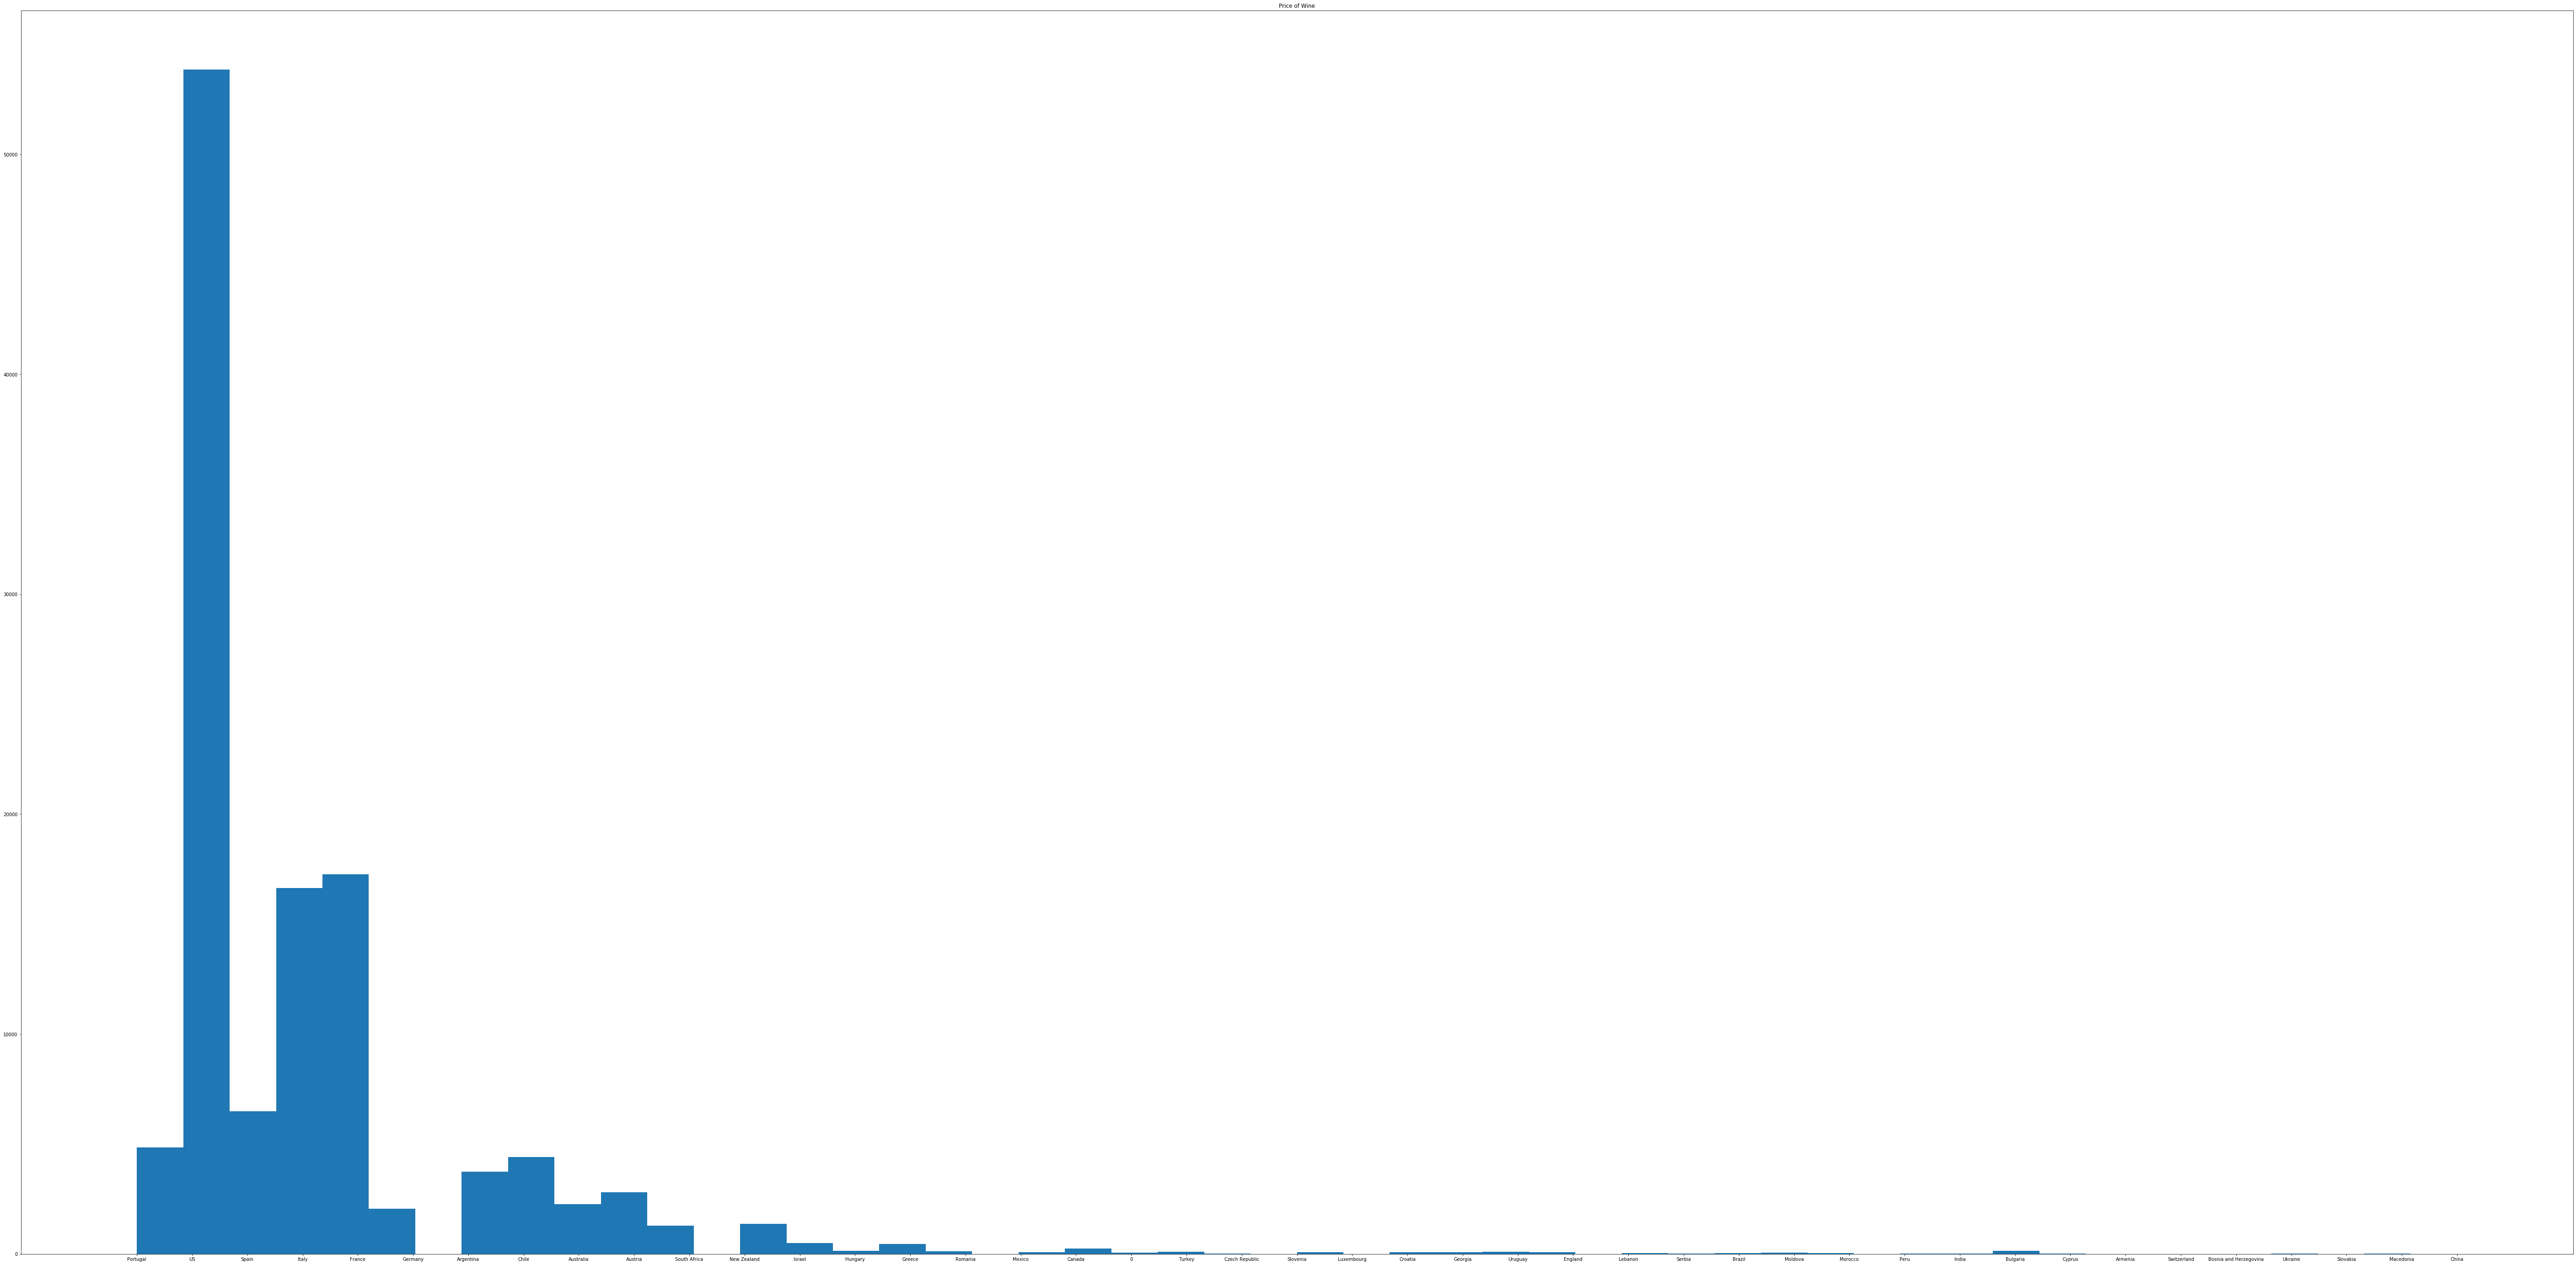

In [171]:
fig, ax = plt.subplots(figsize = (100,50))
ax.hist(data['country'],bins = 50)
ax.set_title('Price of Wine')
plt.show()

In [262]:
data[data['country']=='Romania']['taster_name'].unique()

array(['Jeff Jenssen', 'Anna Lee C. Iijima', 'Susan Kostrzewa'],
      dtype=object)

In [261]:
#thinking taster name have correlation to countries since with expensie wine, they do.But the result is not obvious. 
country = ['Portugal','US','Spain','Italy','France','Germany','Argentina', 'Chile','Australia','Austria','New Zealand']
data_tmp = data[~data['country'].isin(country)]
x = data_tmp['country']
y = data_tmp['taster_name']
confusion_matrix = pd.crosstab(x, y).values
cramers_v(confusion_matrix)


0.6979310963504548

Province Region_1 Country and Winery contains a lot of same info. We use hashing scheme to get different set of encoding and test which is better

In [322]:
# https://towardsdatascience.com/understanding-feature-engineering-part-2-categorical-data-f54324193e63

def hash_f(features,n ,data = data['country']):
    fh = FeatureHasher(n_features=n, input_type='string')
    hashed_features = fh.fit_transform(data)
    hashed_features = hashed_features.toarray()
    return hashed_features


In [301]:
country_hash = hash_f('country')

In [302]:
Xtrain_rawpoints = np.vstack((country_hash.T,np.ones(len(country_hash)))).T
Xtrain_rawpoints

array([[ 0.,  2.,  1., ...,  1., -1.,  1.],
       [-1.,  0.,  0., ..., -1.,  0.,  1.],
       [-1.,  0.,  0., ..., -1.,  0.,  1.],
       ...,
       [-1.,  2.,  0., ...,  0., -1.,  1.],
       [-1.,  2.,  0., ...,  0., -1.,  1.],
       [-1.,  2.,  0., ...,  0., -1.,  1.]])

In [303]:
def MSE(y,pred):
  a = ((y-pred)**2).sum()/len(y)
  return a 

#split data training 80%  and testing 80%
data = shuffle(data) 
train_proportion = 0.8
n = len(data)
print("Size of dataset: ", str(n))
n_train = round(train_proportion*n)
target = data['price']
data = data.drop(['price'],axis=1)

# the following variable records the features of examples in the training set
train_x = data.iloc[range(0,n_train),:]
# the following variable records the features of examples in the test set
test_x = data.iloc[range(n_train,n),:]
# the following variable records the labels of examples in the training set
train_y = target.iloc[range(0,n_train)]
# the following variable records the labels of examples in the test set
test_y = target.iloc[range(n_train,n)]




Size of dataset:  119505


In [340]:
def select(features,n):
    train_vals_country = hash_f(features,n,train_x.loc[:,features])
    test_vals_country = hash_f(features,n,test_x.loc[:,features])
    Xtrain_rawpoints = np.vstack((train_vals_country.T,np.ones(len(train_vals_country)))).T
    Xtest_rawpoints = np.vstack((test_vals_country.T,np.ones(len(test_vals_country)))).T
    #print(Xtrain_rawpoints)
    wd_b,resid,rank,s = np.linalg.lstsq(Xtrain_rawpoints,train_y)
    #print(wd_b)

    pred_test_rawpoints = np.dot(Xtest_rawpoints,wd_b)
    pred_train_rawpoints = np.dot(Xtrain_rawpoints,wd_b)

    return MSE(train_y,pred_train_rawpoints),MSE(test_y,pred_test_rawpoints)

In [358]:
def draw():
    a = max(pred_test_rawpoints)
    b = max(0,min(pred_test_rawpoints))
    c = max(test_y)
    d = max(min(test_y),0)
    print("Train MSE\t",MSE(train_y,pred_train_rawpoints))
    print("Test MSE\t",MSE(test_y,pred_test_rawpoints))
    f,ax = plt.subplots(figsize=(8, 6))
    ax.scatter(pred_test_rawpoints[1:1000],test_y[1:1000])
    ax.plot([0,600],[0,600])
    ax.set_xlim([b,a])
    ax.set_ylim([d,c])
    ax.set_xlabel("Predicted Value")
    ax.set_ylabel("True Value")

# Country


In [385]:
train_tmp = []
test_tmp = []
for i in range(1,40):
    train_mse,test_mse = select('country',i)
    train_tmp.append(train_mse)
    test_tmp.append(test_mse)
   
    

    

C:\YZC\Conda\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  import sys


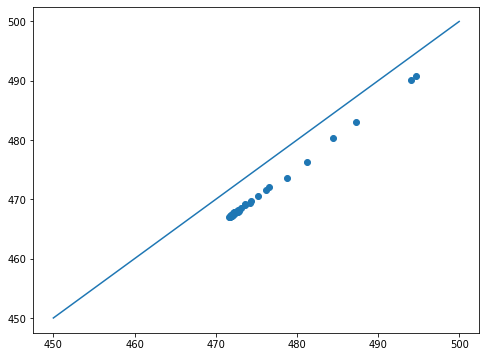

In [386]:
f,ax = plt.subplots(figsize=(8, 6))
ax.scatter(train_tmp,test_tmp)
ax.plot([450,500],[450,500])
#not overfitting as features goes up and we try to select best number of features

[494.63000791252716,
 494.00357723971916,
 481.2336797574528,
 484.4564702601313,
 475.21389305767485,
 478.8324267463409,
 487.3380259722956,
 476.5901615577121,
 474.2894287897859,
 472.7436548339167,
 472.7210106551832,
 473.61715218887736,
 473.60859709156273,
 476.15975366714554,
 473.14656449571885,
 472.3801584430328,
 472.8437294481808,
 472.4155600772217,
 472.4373357153013,
 472.49046641942533,
 472.037412421001,
 472.38990431754115,
 474.2366372384809,
 472.11973348536145,
 472.64671705754296,
 471.8071912686646,
 472.2238013781603,
 471.7438057508529,
 471.90964675389796,
 472.09245185407985,
 471.84827783955024,
 472.2709096901796,
 472.31385517056015,
 472.0998482902262,
 471.8393535854629,
 471.8339192262984,
 471.7559492605648,
 472.28240628886846,
 471.5987743579663]

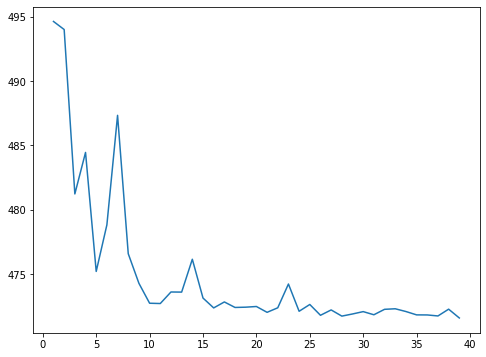

In [387]:
f,ax = plt.subplots(figsize=(8, 6))
ax.plot(range(1,40),train_tmp)
#We select 10 features for Country and the following is MSE
  

In [388]:
train_mse,test_mse = select('country',20)
print("Train MSE\t",train_mse)
print("Test MSE\t",test_mse)

Train MSE	 472.49046641942533
Test MSE	 467.82698492093


C:\YZC\Conda\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  import sys


# Province

In [389]:
#Since with many province we use larger numbers of features
train_tmp = []
test_tmp = []
for i in range(1,60):
    train_mse,test_mse = select('province',i)
    train_tmp.append(train_mse)
    test_tmp.append(test_mse)

C:\YZC\Conda\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  import sys


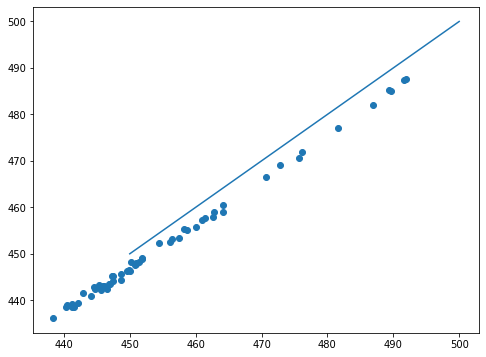

In [390]:
f,ax = plt.subplots(figsize=(8, 6))
ax.scatter(train_tmp,test_tmp)
ax.plot([450,500],[450,500])
#not overfitting as features goes up and we try to select best number of features

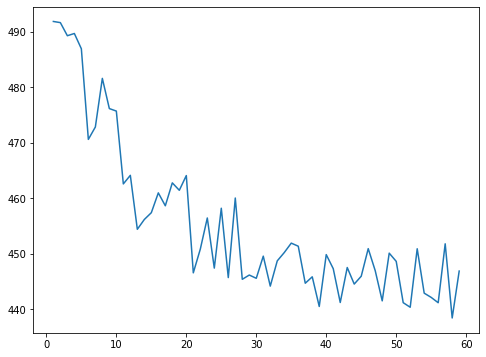

In [391]:
f,ax = plt.subplots(figsize=(8, 6))
ax.plot(range(1,60),train_tmp)
#We select 20 features for Province

In [392]:
train_mse,test_mse = select('province',20)
print("Train MSE\t",train_mse)
print("Test MSE\t",test_mse)

Train MSE	 464.09133920458
Test MSE	 458.9497584926736


C:\YZC\Conda\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  import sys


# Region_1

In [401]:
train_tmp = []
test_tmp = []
for i in range(1,150):
    train_mse,test_mse = select('region_1',i)
    train_tmp.append(train_mse)
    test_tmp.append(test_mse)

C:\YZC\Conda\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  import sys


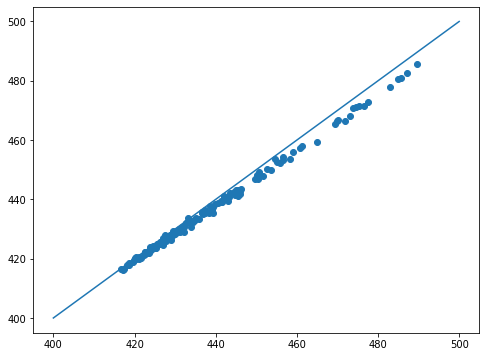

In [403]:
f,ax = plt.subplots(figsize=(8, 6))
ax.scatter(train_tmp,test_tmp)
ax.plot([400,500],[400,500])

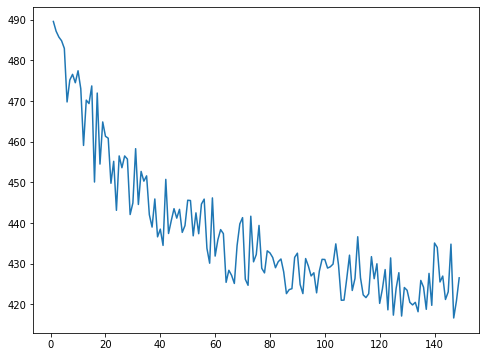

In [405]:
f,ax = plt.subplots(figsize=(8, 6))
ax.plot(range(1,150),train_tmp)

In [400]:
#We can se mse even decrease furthur and we can choose 60 features
train_mse,test_mse = select('region_1',60)
print("Train MSE\t",train_mse)
print("Test MSE\t",test_mse)

Train MSE	 431.8589571190066
Test MSE	 430.7515417859964


C:\YZC\Conda\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  import sys


#  Winery

In [422]:
train_tmp = []
test_tmp = []
for i in range(1,100):
    train_mse,test_mse = select('winery',i)
    train_tmp.append(train_mse)
    test_tmp.append(test_mse)

C:\YZC\Conda\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  import sys


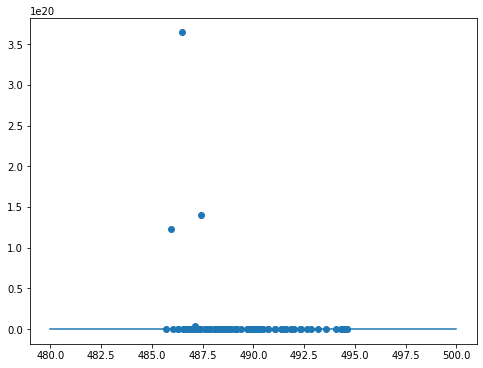

In [423]:
f,ax = plt.subplots(figsize=(8, 6))
ax.scatter(train_tmp,test_tmp)
ax.plot([480,500],[480,500])

#it is overfitting with large features  

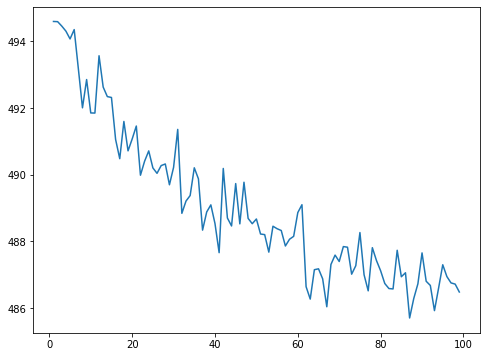

In [425]:
# we can see from this graph, the mse of training sets is still much larger than the model we used in region_1 and 
#when numbers of features increases, it cause obvious overfitting. 
f,ax = plt.subplots(figsize=(8, 6))
ax.plot(range(1,100),train_tmp)


In [426]:

train_mse,test_mse = select('winery',50)
print("Train MSE\t",train_mse)
print("Test MSE\t",test_mse)

Train MSE	 488.6734596412033
Test MSE	 484.8520973244939


C:\YZC\Conda\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  import sys


In [441]:
data_2 = df[['designation','points','price','region_1','taster_name','variety']]
data_2 = data_2[data_2['price']<150]
data_2

,designation,points,price,region_1,taster_name,variety
1,Avidagos,87,15.0,NaN,Roger Voss,Portuguese Red
2,NaN,87,14.0,Willamette Valley,Paul Gregutt,Pinot Gris
3,Reserve Late Harvest,87,13.0,Lake Michigan Shore,Alexander Peartree,Riesling
4,Vintner's Reserve Wild Child Block,87,65.0,Willamette Valley,Paul Gregutt,Pinot Noir
5,Ars In Vitro,87,15.0,Navarra,Michael Schachner,Tempranillo-Merlot
...,...,...,...,...,...,...
129966,Brauneberger Juffer-Sonnenuhr Spätlese,90,28.0,NaN,Anna Lee C. Iijima,Riesling
129967,NaN,90,75.0,Oregon,Paul Gregutt,Pinot Noir
129968,Kritt,90,30.0,Alsace,Roger Voss,Gewürztraminer
129969,NaN,90,32.0,Alsace,Roger Voss,Pinot Gris


In [440]:
export_csv = data_2.to_csv(r'C:\Users\Yuanzheng Cao\Desktop\Cornell\Cornell_2019_Fall\ORIE_4741\export_dataframe.csv',index = None,header = True)

In [435]:
# to predict region_1 by country, province, winery and   

,designation,points,price,region_1,taster_name,variety
1,Avidagos,87,15.0,NaN,Roger Voss,Portuguese Red
2,NaN,87,14.0,Willamette Valley,Paul Gregutt,Pinot Gris
3,Reserve Late Harvest,87,13.0,Lake Michigan Shore,Alexander Peartree,Riesling
4,Vintner's Reserve Wild Child Block,87,65.0,Willamette Valley,Paul Gregutt,Pinot Noir
5,Ars In Vitro,87,15.0,Navarra,Michael Schachner,Tempranillo-Merlot
...,...,...,...,...,...,...
129966,Brauneberger Juffer-Sonnenuhr Spätlese,90,28.0,NaN,Anna Lee C. Iijima,Riesling
129967,NaN,90,75.0,Oregon,Paul Gregutt,Pinot Noir
129968,Kritt,90,30.0,Alsace,Roger Voss,Gewürztraminer
129969,NaN,90,32.0,Alsace,Roger Voss,Pinot Gris


In [453]:
data_r = data[['country','region_1','province','winery']]
data_r[data_r['country']=='0']

,country,region_1,province,winery
129590,0,0,0,Büyülübağ
44850,0,0,0,Stone Castle
129900,0,0,0,Psagot
97850,0,0,0,Neumeister
113520,0,0,0,El Capricho
105167,0,0,0,Neumeister
16000,0,0,0,Familia Deicas
120799,0,0,0,Ktima Voyatzi
118118,0,0,0,Gotsa Family Wines
27822,0,0,0,Mt. Beautiful


In [454]:
export_csv = data_r.to_csv(r'C:\Users\Yuanzheng Cao\Desktop\Cornell\Cornell_2019_Fall\ORIE_4741\region_1.csv',index = None,header = True)

In [461]:
# Implement multinomial logistic regression to predict region_1 with data_r_new.
#https://sweetcode.io/machine-learning-multinomial-logistic-regression/
# Due to our model_training datasets does not have missing value, we have to use winery to predict country and
#use winery and country predict province and lastly we use all of them to predict region_1
data_r_NA = data_r[data_r['region_1'] == '0']
data_r_new = data_r[data_r['region_1'] !='0']

,country,region_1,province,winery
2450,Italy,Brunello di Montalcino,Tuscany,Ruffino
128371,US,Southern Oregon,Oregon,DanCin
105396,US,Monterey,California,DeTierra Vineyards
844,Italy,Etna,Sicily & Sardinia,Cottanera
78538,Italy,Langhe,Piedmont,Elvio Cogno
...,...,...,...,...
216,Italy,Brunello di Montalcino,Tuscany,Podere Scopetone
72298,Italy,Rosso di Montalcino,Tuscany,Capanne Ricci
64438,US,Santa Ynez Valley,California,Archium
84244,US,Russian River Valley,California,La Crema


In [ ]:
def hash_f(features,n ,data = data['country']):
    fh = FeatureHasher(n_features=n, input_type='string')
    hashed_features = fh.fit_transform(data)
    hashed_features = hashed_features.toarray()
    return hashed_features

Xtrain_rawpoints = np.vstack((country_hash.T,np.ones(len(country_hash)))).T

In [496]:
def m_log(X,Y):
    train_x, test_x, train_y, test_y = train_test_split(X,Y , test_size=0.2, random_state=0)
    clf = LogisticRegression(solver='lbfgs',multi_class='multinomial')
    clf.fit(train_x, train_y)
    print(clf.score(test_x, test_y))



In [517]:
# Model to predict country: 
Y = data_r_new.loc[:,'province'].values

hash_1 = hash_f('winery',60, data = data_r_new['winery'])

X = np.vstack((hash_1.T,np.ones(len(hash_1)))).T


m_log(X,Y)

0.42575197361846706


C:\YZC\Conda\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [522]:
Y = data_r_new.loc[:,'province'].values

hash_1 = hash_f('country',60, data = data_r_new['country'])

X = np.vstack((hash_1.T,np.ones(len(hash_1)))).T


m_log(X,Y)

0.5243829319476366


C:\YZC\Conda\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [630]:
data=data.fillna('0')

In [812]:
# Due to one winery could have severl corresponding country or province and and the same reason 
# when use country to predict province. The result is pretty bad we decide to randomly choose 
# Get all regions in different province and if province is not missing, randomly choose region from that province. 
province = data['province'].unique()

dict_c={}


for i in province:
    tmp = data[df['province'] == i].region_1.unique()
  
    if np.mean(tmp==['0']) == 1:
            
        dict_c[i] = [i]
        
    else:
        dict_c[i] = tmp.tolist()



    

    


C:\YZC\Conda\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.


In [903]:
count= 0
for i in range(data.shape[0]):
    while data.iloc[i,6] == '0':
        r = dict_c[data.iloc[i,5]]
        t = random.choice(r)
        data.iloc[i,6]= t
   

In [860]:
#split data training 80%  and testing 80%
data = shuffle(data) 
train_proportion = 0.8
n = len(data)
print("Size of dataset: ", str(n))
n_train = round(train_proportion*n)
target = data['price']
data = data.drop(['price'],axis=1)

# the following variable records the features of examples in the training set
train_x = data.iloc[range(0,n_train),:]
# the following variable records the features of examples in the test set
test_x = data.iloc[range(n_train,n),:]
# the following variable records the labels of examples in the training set
train_y = target.iloc[range(0,n_train)]
# the following variable records the labels of examples in the test set
test_y = target.iloc[range(n_train,n)]

Size of dataset:  119446


In [861]:
train_mse,test_mse = select('region_1',60)
print("Train MSE\t",train_mse)
print("Test MSE\t",test_mse)

#Even we imputed some missing value, however, we do not get mroe information from this imputing by province
# since mse is almost same and means information are redudant. However, when people do not know the region_1, we can use province
# as indicator to give some information under this model and sacrificing the acurrancy if people have region_1 information

C:\YZC\Conda\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  import sys


Train MSE	 443.2369425450432
Test MSE	 436.7367125166041


In [946]:
data_update = data[['price','designation','points','region_1','taster_name','variety','winery']]

In [947]:
data_update

,price,designation,points,region_1,taster_name,variety,winery
1,15.0,Avidagos,87,Douro,Roger Voss,Portuguese Red,Quinta dos Avidagos
2,14.0,0,87,Willamette Valley,Paul Gregutt,Pinot Gris,Rainstorm
3,13.0,Reserve Late Harvest,87,Lake Michigan Shore,Alexander Peartree,Riesling,St. Julian
4,65.0,Vintner's Reserve Wild Child Block,87,Willamette Valley,Paul Gregutt,Pinot Noir,Sweet Cheeks
5,15.0,Ars In Vitro,87,Navarra,Michael Schachner,Tempranillo-Merlot,Tandem
...,...,...,...,...,...,...,...
129966,28.0,Brauneberger Juffer-Sonnenuhr Spätlese,90,Mosel,Anna Lee C. Iijima,Riesling,Dr. H. Thanisch (Erben Müller-Burggraef)
129967,75.0,0,90,Oregon,Paul Gregutt,Pinot Noir,Citation
129968,30.0,Kritt,90,Alsace,Roger Voss,Gewürztraminer,Domaine Gresser
129969,32.0,0,90,Alsace,Roger Voss,Pinot Gris,Domaine Marcel Deiss


In [948]:
# Using catboost to do furthur feature selection. https://github.com/catboost/catboost
X = data_update.drop(columns = ['price'])
y = data_update['price']
categorical_features_indices =[0,1,2,3,4,5]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=52)
                                                    


In [949]:
def perform_model(X_train, y_train,X_valid, y_valid,X_test, y_test):
    model = CatBoostRegressor(
        random_seed = 400,
        loss_function = 'RMSE',
        iterations=400,
    )
    
    model.fit(
        X_train, y_train,
        cat_features = categorical_features_indices,
        eval_set=(X_valid, y_valid),
        verbose=False
    )
    
    print("MSE on training data: "+ model.score(X_train, y_train).astype(str))
    print("MSE on test data: "+ model.score(X_test, y_test).astype(str))
    
    return model

In [950]:
model=perform_model(X_train, y_train,X_valid, y_valid,X_test, y_test)

MSE on training data: 0.7006604489417416
MSE on test data: 0.658947320980776


In [951]:
feature_score = pd.DataFrame(list(zip(X.dtypes.index, model.get_feature_importance(Pool(X, label=y, cat_features=categorical_features_indices)))),
                columns=['Feature','Score'])

feature_score = feature_score.sort_values(by='Score', ascending=False, inplace=False, kind='quicksort', na_position='last')

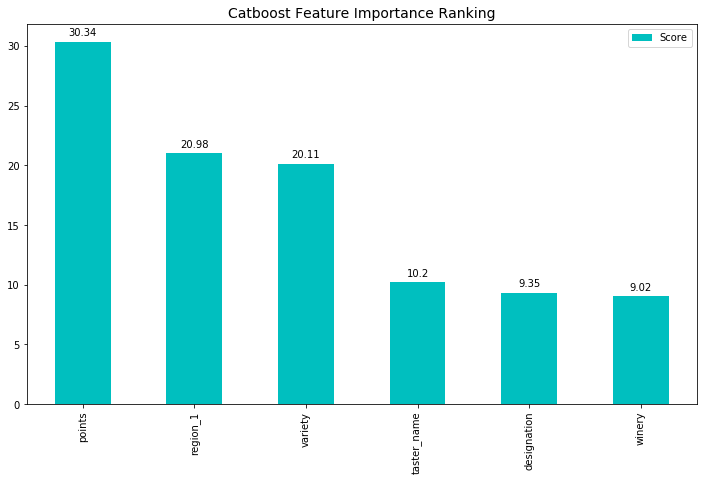

In [952]:
plt.rcParams["figure.figsize"] = (12,7)
ax = feature_score.plot('Feature', 'Score', kind='bar', color='c')
ax.set_title("Catboost Feature Importance Ranking", fontsize = 14)
ax.set_xlabel('')

rects = ax.patches

labels = feature_score['Score'].round(2)

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 0.35, label, ha='center', va='bottom')

plt.show()

In [ ]:
# As we can see for the graph. all features are important right now. 
# If we have to drop features, I will try to drop taster_name and designationa and see the results of fitting model

In [953]:
X = data_update.drop(columns = ['price'])
y = data_update['price']
categorical_features_indices =[0,1,2,3,4]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=52)

In [956]:
# drop taster_name
X = data_update.drop(columns=['price','taster_name'])
y = data_update['price']
categorical_features_indices =[0,1,2,3,4]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=52)



In [957]:
model=perform_model(X_train, y_train,X_valid, y_valid,X_test, y_test)
# model even improved

MSE on training data: 0.6911295202149659
MSE on test data: 0.6481562706467707


In [959]:
#drop designation 
X = data_update.drop(columns=['price','designation'])
y = data_update['price']
categorical_features_indices =[0,1,2,3,4]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=52)
model=perform_model(X_train, y_train,X_valid, y_valid,X_test, y_test)

MSE on training data: 0.6600513406470273
MSE on test data: 0.6306989290129559


In [960]:
# drop winery
X = data_update.drop(columns=['price','winery'])
y = data_update['price']
categorical_features_indices =[0,1,2,3,4]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=52)
model=perform_model(X_train, y_train,X_valid, y_valid,X_test, y_test)

MSE on training data: 0.6736036718685647
MSE on test data: 0.6294918405928471


From the statsitics, we can that it seems have no issue to drop any one of them. I will consider to drop both designation and winery for two reason: 1) both of them have tons of categories and it is hard to use one hot encoding, some information in winery have alreadybeen contained in region_2 as showing in the correlation analysis.2) designation have too many missing values and it could potential cause overfitting.

In [972]:
# Performance after drop winery and designation: it not only reduce the features, but also reduce the mse. 
X = data_update.drop(columns=['price','winery','designation'])
y = data_update['price']
categorical_features_indices =[0,1,2,3]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=52)
model=perform_model(X_train, y_train,X_valid, y_valid,X_test, y_test)

MSE on training data: 0.6031895969412986
MSE on test data: 0.5872858093907181


In [965]:

taster = data_update['taster_name'].unique()
t_times = []
for i in taster:
    time = sum(data_update['taster_name'] == i)
    t_times.append(time)

y_pos = np.arange(len(taster))




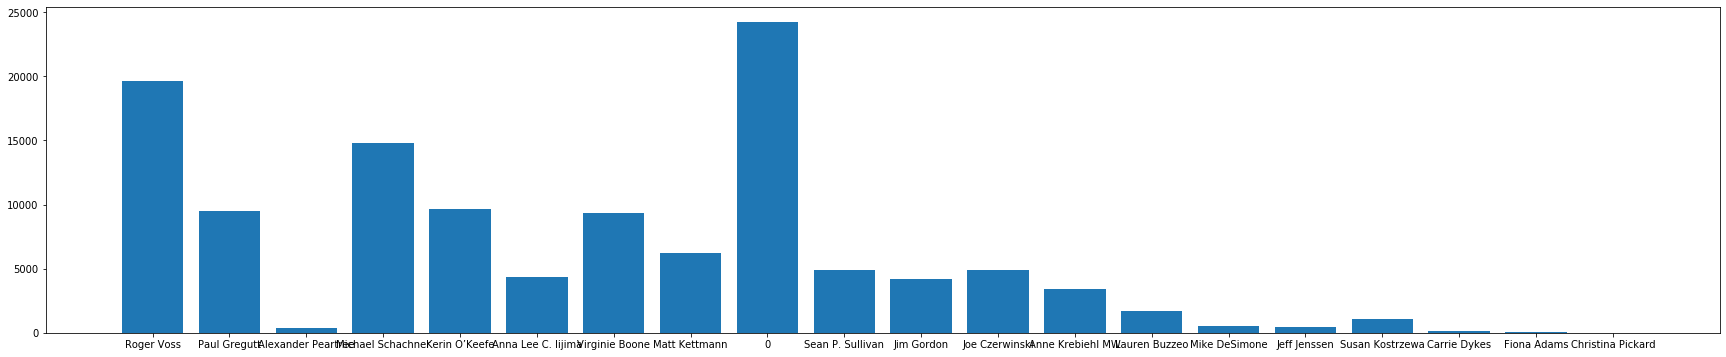

In [966]:
f,ax = plt.subplots(figsize=(30, 6))
ax.bar(y_pos, t_times, align='center')
plt.xticks(y_pos, taster)

plt.show()

In [969]:
w = data_update['winery'].unique()
t_times = []
for i in w:
    time = sum(data_update['winery'] == i)
    t_times.append(time)

y_pos = np.arange(len(w))



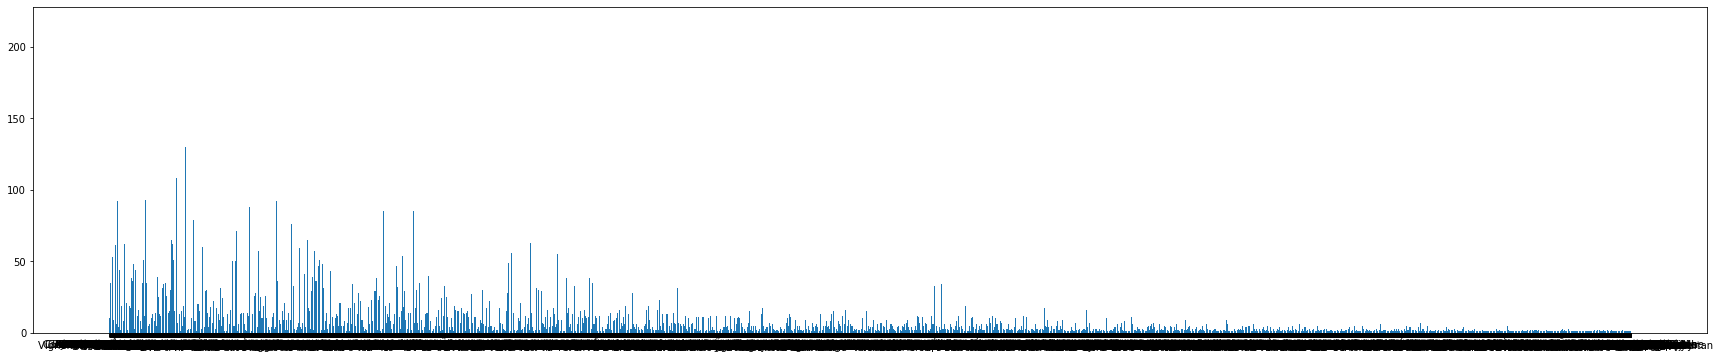

In [970]:
f,ax = plt.subplots(figsize=(30, 6))
ax.bar(y_pos, t_times, align='center')
plt.xticks(y_pos, w)

plt.show()

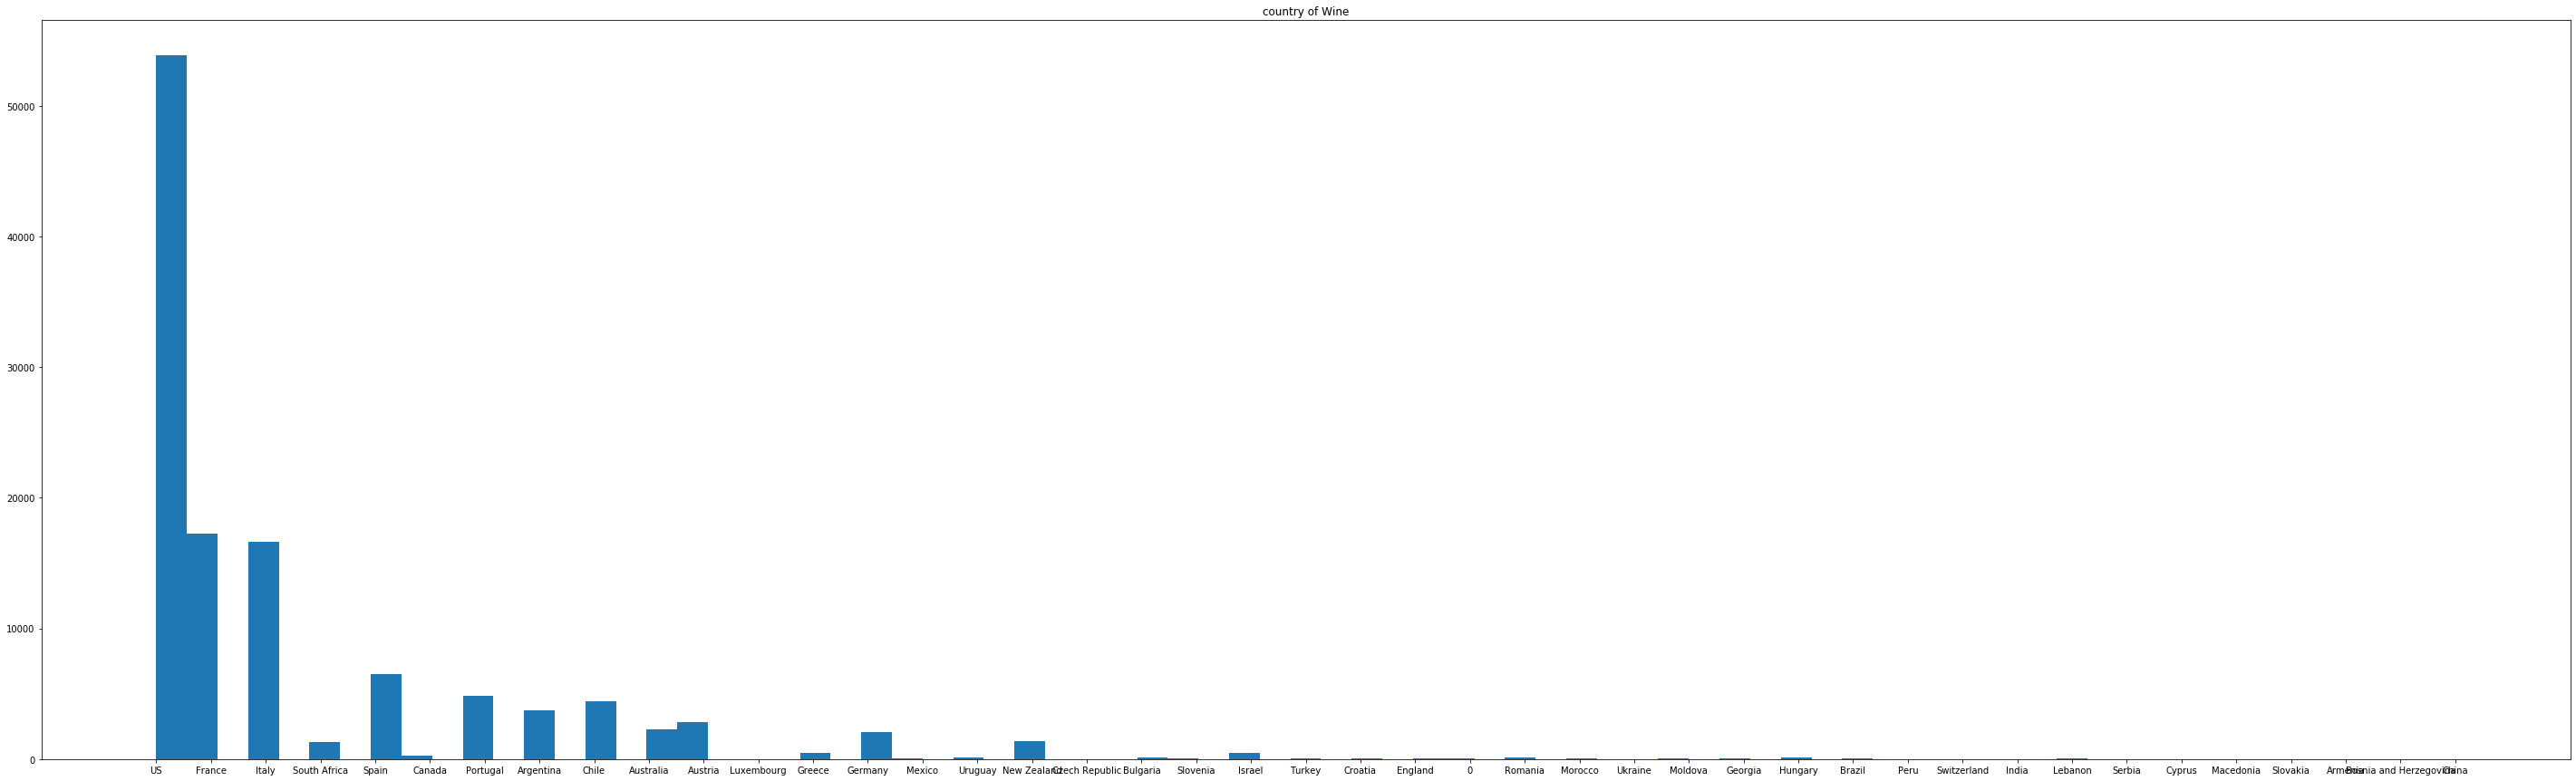

In [86]:
fig, ax = plt.subplots(figsize = (50,15))
ax.hist(df_c['country'],bins = 75)
ax.set_title('country of Wine')
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize = (8,6))
ax.hist(df['price'],range=[0, 150])
ax.set_title('Price of Wine')
plt.show()

In [42]:
df_points = df['points']
df_price = df['price']

(0, 200)

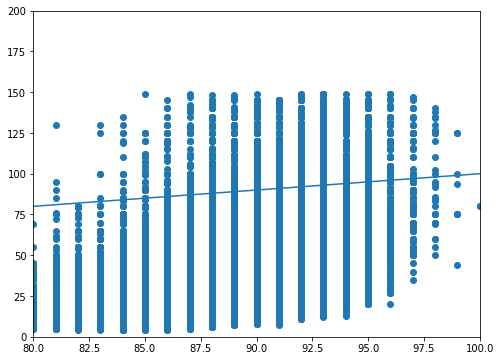

In [43]:
f,ax = plt.subplots(figsize=(8, 6))
ax.scatter(df_points,df_price)
ax.plot([0,600],[0,600])
ax.set_xlim([80,100])
ax.set_ylim([0,200])

In [44]:
#split data training 80%  and testing 80%
df = shuffle(df) 
train_proportion = 0.8
n = len(df)
print("Size of dataset: ", str(n))
n_train = round(train_proportion*n)
target = df['price']
data = df.drop(['price'],axis=1)

Size of dataset:  119505


In [45]:
# the following variable records the features of examples in the training set
train_x = data.iloc[range(0,n_train),:]
# the following variable records the features of examples in the test set
test_x = data.iloc[range(n_train,n),:]
# the following variable records the labels of examples in the training set
train_y = target.iloc[range(0,n_train)]
# the following variable records the labels of examples in the test set
test_y = target.iloc[range(n_train,n)]



In [46]:
# raw_score
train_vals_raw = train_x.loc[:,'points']
test_vals_raw = test_x.loc[:,'points']
Xtrain_rawpoints = np.vstack((train_vals_raw.T,np.ones(len(train_vals_raw)))).T
Xtest_rawpoints = np.vstack((test_vals_raw.T,np.ones(len(test_vals_raw)))).T

In [47]:
def MSE(y,pred):
  a = ((y-pred)**2).sum()/len(y)
  return a 

In [48]:
wd_b,resid,rank,s = np.linalg.lstsq(Xtrain_rawpoints,train_y)
print(wd_b)

[   4.04824915 -325.17692752]


C:\Users\YCZ\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  """Entry point for launching an IPython kernel.


Train MSE	 348.01183828799867
Test MSE	 344.5547293320421


Text(0, 0.5, 'True Value')

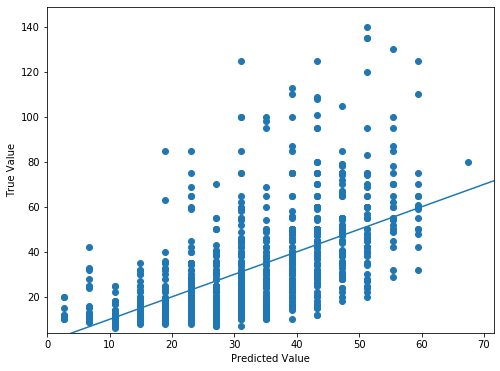

In [49]:
pred_test_rawpoints = np.dot(Xtest_rawpoints,wd_b)
pred_train_rawpoints = np.dot(Xtrain_rawpoints,wd_b)
a = max(pred_test_rawpoints)
b = max(0,min(pred_test_rawpoints))
c = max(test_y)
d = max(min(test_y),0)
print("Train MSE\t",MSE(train_y,pred_train_rawpoints))
print("Test MSE\t",MSE(test_y,pred_test_rawpoints))
f,ax = plt.subplots(figsize=(8, 6))
ax.scatter(pred_test_rawpoints[1:1000],test_y[1:1000])
ax.plot([0,600],[0,600])
ax.set_xlim([b,a])
ax.set_ylim([d,c])
ax.set_xlabel("Predicted Value")
ax.set_ylabel("True Value")

[   69.71464491 -5796.34581872 19845.05893464]
Train MSE	 329.4753492985525
Test MSE	 327.57888579323657


C:\Users\YCZ\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  """


Text(0, 0.5, 'True Value')

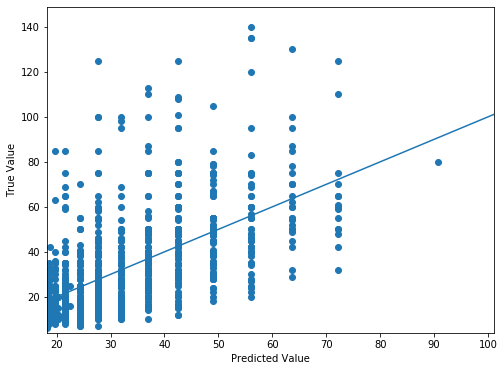

In [50]:
train_vals_t = np.log(train_vals_raw)
test_vals_t = np.log(test_vals_raw)
Xtrain_tpoints = np.vstack((train_vals_raw.T, train_vals_t.T,np.ones(len(train_vals_t)))).T
Xtest_tpoints = np.vstack((test_vals_raw, test_vals_t.T,np.ones(len(test_vals_t)))).T
wd_b,resid,rank,s = np.linalg.lstsq(Xtrain_tpoints,train_y)
print(wd_b)
pred_test_tpoints = np.dot(Xtest_tpoints,wd_b)
pred_train_tpoints = np.dot(Xtrain_tpoints,wd_b)
a = max(pred_test_tpoints)
b = max(0,min(pred_test_tpoints))
c = max(test_y)
d = max(min(test_y),0)
print("Train MSE\t",MSE(train_y,pred_train_tpoints))
print("Test MSE\t",MSE(test_y,pred_test_tpoints))
f,ax = plt.subplots(figsize=(8, 6))
ax.scatter(pred_test_tpoints[1:1000],test_y[1:1000])
ax.plot([0,600],[0,600])
ax.set_xlim([b,a])
ax.set_ylim([d,c])
ax.set_xlabel("Predicted Value")
ax.set_ylabel("True Value")

In [51]:
Xtrain_tpoints = np.vstack((train_vals_raw.T,(train_vals_raw.T**2),np.ones(len(train_vals_t)))).T
Xtest_tpoints = np.vstack((test_vals_raw,(test_vals_raw.T**2),np.ones(len(test_vals_t)))).T
wd_b,resid,rank,s = np.linalg.lstsq(Xtrain_tpoints,train_y)
print(wd_b)

[-6.20693745e+01  3.74139160e-01  2.59252973e+03]


C:\Users\YCZ\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  This is separate from the ipykernel package so we can avoid doing imports until


Train MSE	 329.38210245428434
Test MSE	 327.4598108499618


Text(0, 0.5, 'True Value')

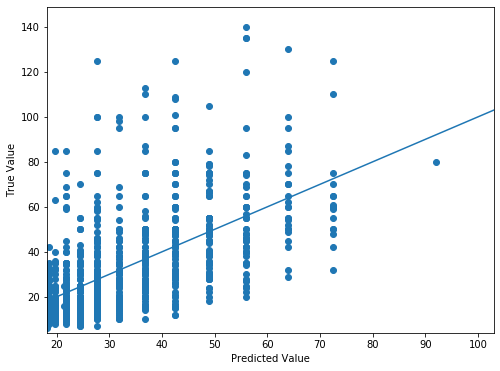

In [52]:
pred_test_tpoints = np.dot(Xtest_tpoints,wd_b)
pred_train_tpoints = np.dot(Xtrain_tpoints,wd_b)
a = max(pred_test_tpoints)
b = max(0,min(pred_test_tpoints))
c = max(test_y)
d = max(min(test_y),0)
print("Train MSE\t",MSE(train_y,pred_train_tpoints))
print("Test MSE\t",MSE(test_y,pred_test_tpoints))
f,ax = plt.subplots(figsize=(8, 6))
ax.scatter(pred_test_tpoints[1:1000],test_y[1:1000])
ax.plot([0,600],[0,600])
ax.set_xlim([b,a])
ax.set_ylim([d,c])
ax.set_xlabel("Predicted Value")
ax.set_ylabel("True Value")

Correlation Analysis